# Q3)
Calculate three local and three global graph theoretic measures for the connectivity matrix corresponding to each condition (EC and EO). Discuss your results and what information they provide about each condition.

In [34]:
# Import the requred Packages
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import nibabel as nib

fmri_file = '../../datasets/fMRI/HW4/sub-001_ses-001_task-eoec_bold.nii.gz' # Get the nifti file
img = nib.load(fmri_file) # Load in the nifti file
print(type(img)) # Print the type of the img variable (should be nifti)
print(img.shape) # Print the dimensions of the object

<class 'nibabel.nifti1.Nifti1Image'>
(64, 64, 35, 120)


## Import Masker & Atlas
To get the ROI time series data from the whole fMRI dataset.

In [35]:
# Load the required Packages
import nilearn as nl
import numpy as np
# Retrieve the atlas and the data
from nilearn import datasets
# Fetch the atlas file.
atlas = datasets.fetch_atlas_msdl()
# Loading the the Probabilistic atlas image
atlas_filename = atlas['maps']
# Loading the list containing the labels of the regions
labels = atlas['labels']
# Extract time series
data = img.get_fdata() # Get the 4 dimentional data from the fMRI
# import maskers
from nilearn.maskers import NiftiMapsMasker
masker = NiftiMapsMasker(maps_img=atlas_filename, standardize=True, memory='nilearn_cache', verbose=5) # get masker from atlas
time_series = masker.fit_transform(img) # get time series from fMRI fitted with the given masker

[NiftiMapsMasker.wrapped] loading regions from None
Resampling maps
[Memory]0.0s, 0.0min    : Loading resample_img...
________________________________________resample_img cache loaded - 0.0s, 0.0min


/home/joshua/.local/lib/python3.10/site-packages/nilearn/maskers/base_masker.py:253: UserWarning: memory_level is currently set to 0 but a Memory object has been provided. Setting memory_level to 1.
  return self.transform_single_imgs(


[Memory]0.3s, 0.0min    : Loading _filter_and_extract...
__________________________________filter_and_extract cache loaded - 0.0s, 0.0min


## Split EO (Eyes Open) & EC (Eyes Closed) data 
into 2 different time series arrays at all ROIs.

In [36]:
# Timing table (onset, duration, trial_type) fitted to the timed intervals (120)
timing_info = [
    (0, 10, "EC"), (10, 10, "EO"), (20, 10, "EC"), (30, 10, "EO"),
    (40, 10, "EC"), (50, 10, "EO"), (60, 10, "EC"), (70, 10, "EO"),
    (80, 10, "EC"), (90, 10, "EO"), (100, 10, "EC"), (110, 10, "EO")
]

# Initialize masks
ec_mask = np.zeros(120, dtype=bool)  # For EC condition
eo_mask = np.zeros(120, dtype=bool)  # For EO condition

# Create masking indecies for EC and EO
for onset, duration, trial_type in timing_info:
    if trial_type == "EC":
        ec_mask[onset:onset + duration] = True
    elif trial_type == "EO":
        eo_mask[onset:onset + duration] = True

# Apply masks to the 4D fMRI data
ec_data = data[..., ec_mask]  # EC condition data
eo_data = data[..., eo_mask]  # EO condition data

# Get random ROI (region of interest)
roi_time_series = time_series[:]  # Full time series for the all ROI
roi_ec_time_series = roi_time_series[ec_mask]  # Time series for EC condition
roi_eo_time_series = roi_time_series[eo_mask]  # Time series for EO condition


## Local Graph Measures EO (eyes open)

Clustering Coefficients: {0: 0.001422475106685633, 1: 0.041251778093883355, 2: 0.041251778093883355, 3: 0.025604551920341393, 4: 0.01849217638691323, 5: 0.02418207681365576, 6: 0.02702702702702703, 7: 0.041251778093883355, 8: 0.01849217638691323, 9: 0.03556187766714083, 10: 0, 11: 0.09388335704125178, 12: 0.03556187766714083, 13: 0, 14: 0.005689900426742532, 15: 0.001422475106685633, 16: 0.031294452347083924, 17: 0.05832147937411095, 18: 0.032716927453769556, 19: 0.01849217638691323, 20: 0.06827880512091039, 21: 0.10810810810810811, 22: 0.002844950213371266, 23: 0.05832147937411095, 24: 0.08819345661450925, 25: 0.015647226173541962, 26: 0.1251778093883357, 27: 0.02418207681365576, 28: 0.001422475106685633, 29: 0.001422475106685633, 30: 0.06116642958748222, 31: 0.05547652916073969, 32: 0.008534850640113799, 33: 0.031294452347083924, 34: 0.029871977240398292, 35: 0.001422475106685633, 36: 0.034139402560455195, 37: 0.001422475106685633, 38: 0.03698435277382646}
Min coef 0
Max coef 0.12517

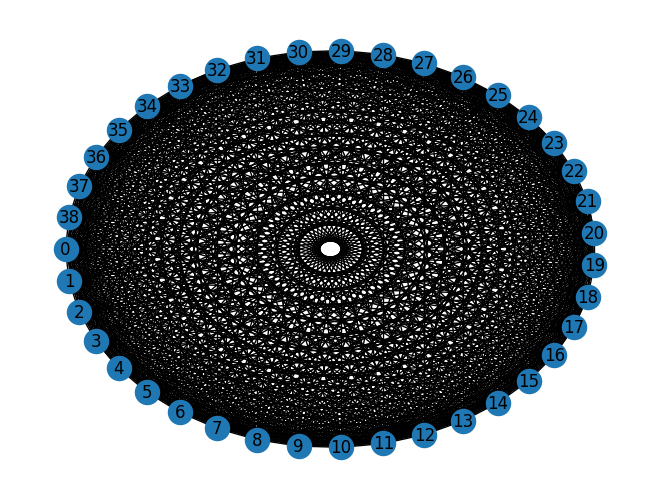

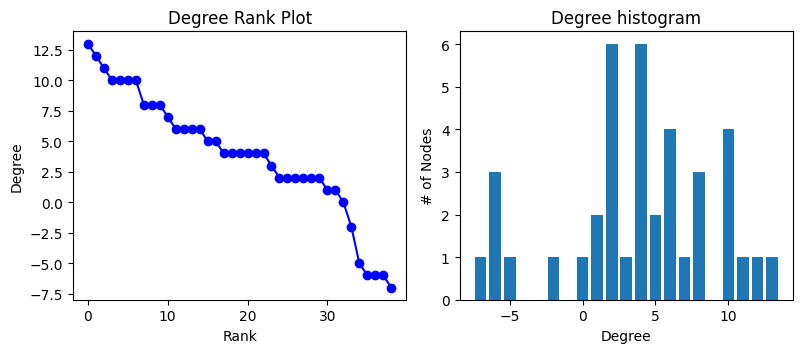

In [66]:
# Import networkx for graph use
import networkx as nx

# from nilearn import plotting
from nilearn.connectome import ConnectivityMeasure

# Display the connectome matrix
from nilearn import plotting

connectivity_measure = ConnectivityMeasure(kind='covariance') # create the covariance object
estimator = connectivity_measure.fit([roi_eo_time_series]) # get the estimator from the covariance object
covariance_matrix = connectivity_measure.fit_transform([roi_eo_time_series])[0]  # extract the single subject's covariance matrix
covariance_matrix = np.array(covariance_matrix) # convert covariance matrix into numpy array

np.fill_diagonal(covariance_matrix, 0) # make sure there are no connections to the node's self

# Convert to NetworkX graphs
eo_graph = nx.from_numpy_array(covariance_matrix)

# Iterate over the graph
for i, j in eo_graph.edges():
    eo_graph[i][j]['weight'] = round(covariance_matrix[i, j]) # round the weights to be a whole number for analysis

clustering_coefficient = nx.clustering(eo_graph, weight='weight') # calculating the cluster coef
print("Clustering Coefficients:", clustering_coefficient) # display the cluster coef
# Get the minimum and maximum coefficients
min_coef = min(clustering_coefficient.values())
max_coef = max(clustering_coefficient.values())
print("Min coef", min_coef)
print("Max coef", max_coef)

widths = nx.get_edge_attributes(eo_graph, 'weight') # get graph edge attributes
pos = nx.shell_layout(eo_graph) # get the positions of the graph
nx.draw(eo_graph,pos,with_labels=True) # draw the graph nodes
nx.draw_networkx_edges(eo_graph, pos,edgelist=widths.keys(),width=list(widths.values())) # draw the graph edges

# Plot the degree distribution in the graph
degree_sequence = sorted((d for n, d in eo_graph.degree(weight='weight')), reverse=True) # get weighted degree distribution
dmin = min(degree_sequence) # get the min weighted degree value
dmax = max(degree_sequence) # get the max weighted degree value
fig = plt.figure(figsize=(8, 8)) # make the plot easily visible
axgrid = fig.add_gridspec(5, 4) # add axis grid
ax1 = fig.add_subplot(axgrid[3:, :2]) # make the first plot
ax1.plot(degree_sequence, "b-", marker="o") # add normal plot for the degree weights
ax1.set_title("Degree Rank Plot") # set the title
ax1.set_ylabel("Degree") # set the y-axis
ax1.set_xlabel("Rank") # set the x-axis
ax2 = fig.add_subplot(axgrid[3:, 2:]) # make the second plot
ax2.bar(*np.unique(degree_sequence, return_counts=True)) # add bar plot the the degree weights
ax2.set_title("Degree histogram") # set the title
ax2.set_xlabel("Degree") # set the y-axis
ax2.set_ylabel("# of Nodes") # set the x-axis
fig.tight_layout() # set the layout for easier visuals
plt.show() # display plot



## Local Graph Measures EO Analysis

**(1)** The Clustering Coefficients are ranging from 0 to 0.125, where 0 is for clusters with low corralation to one another and 0.125 is for the higher weighted clusters with high corralation to one another.

**(2)** All nodes in the graph seem to all be connected to one another directly due to the density of the lines in the graph image.

**(3.a)** The Degree Rank Plot shows the the degree weight along with the rank of that node. Since there are 39 nodes there should roughly be 39 ranks and we can see that from the plot. Values of the weighted degrees are ranging from 13 to around -7, which is around 20 points in separation from the highest weight to the lowest weight.

**(3.b)** The Degree historgram shows the degree weight along with the number of nodes which is similar to the degree rank plot, but shows us a better picuture on the frequncy of each weighted degree. Showing us that degree 2 and 4 had the highest frequency rates which is relatively closer to 0 on the positive side, telling us that there are a lot of loose corralated nodes in the graph. However at around -6 and 10, near the extremes the frequency jumps up to 3+ for both and shows that there are some connections which have high corralation.

## Global Graph Measures EO (eyes open)

In [63]:
global_efficiency = nx.global_efficiency(eo_graph)
average_clustering = nx.average_clustering(eo_graph, weight='weight')

print(global_efficiency)
print(average_clustering)
print(nx.diameter(eo_graph))

1.0
0.03348287558813875
1


## Global Graph Measures EO Analysis
**(1)** The Global efficiency of the graph is 1 which tells us that average graph connection is roughly 1 which is a highly connected graph.

**(2)** The average cluster of the graph is 0.03348 which tells what the average correlation of a cluster roughly is.

**(3)** The diameter of the graph is 1 meaning the longest shortest path between any two nodes is 1 connection.

## Local Graph Measures EC (eyes closed)

Clustering Coefficients: {0: 0.02844950213371266, 1: 0.05263157894736842, 2: 0.14366998577524892, 3: 0.008534850640113799, 4: 0.00995732574679943, 5: 0.16073968705547653, 6: 0.10668563300142248, 7: 0.12091038406827881, 8: 0.015647226173541962, 9: 0.2119487908961593, 10: 0.004267425320056899, 11: 0.14082503556187767, 12: 0.03698435277382646, 13: 0.05547652916073969, 14: 0.001422475106685633, 15: 0.02275960170697013, 16: 0.17496443812233287, 17: 0.16073968705547653, 18: 0, 19: 0.15789473684210525, 20: 0.18492176386913228, 21: 0.14509246088193456, 22: 0.051209103840682786, 23: 0.23044096728307253, 24: 0.2147937411095306, 25: 0.02275960170697013, 26: 0.20768136557610242, 27: 0.02702702702702703, 28: 0.004267425320056899, 29: 0.029871977240398292, 30: 0.20768136557610242, 31: 0.01422475106685633, 32: 0.059743954480796585, 33: 0, 34: 0.17496443812233287, 35: 0.025604551920341393, 36: 0.20910384068278806, 37: 0.001422475106685633, 38: 0.0953058321479374}
Min coef 0
Max coef 0.2304409672830725

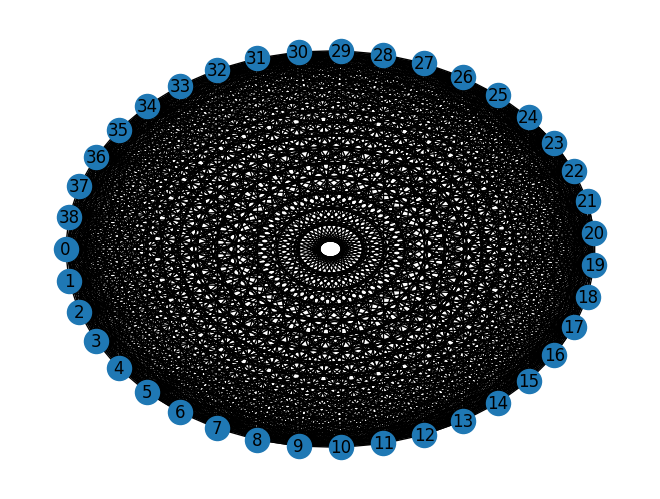

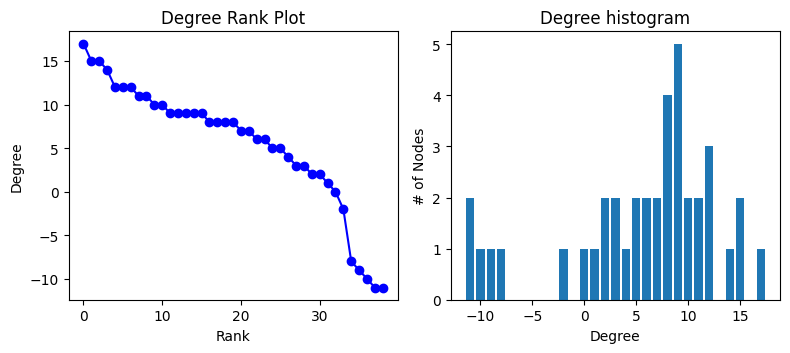

In [68]:
# Import networkx for graph use
import networkx as nx

# from nilearn import plotting
from nilearn.connectome import ConnectivityMeasure

# Display the connectome matrix
from nilearn import plotting

connectivity_measure = ConnectivityMeasure(kind='covariance') # create the covariance object
estimator = connectivity_measure.fit([roi_ec_time_series]) # get the estimator from the covariance object
covariance_matrix = connectivity_measure.fit_transform([roi_ec_time_series])[0]  # extract the single subject's covariance matrix
covariance_matrix = np.array(covariance_matrix) # convert covariance matrix into numpy array

np.fill_diagonal(covariance_matrix, 0) # make sure there are no connections to the node's self

# Convert to NetworkX graphs
graph = nx.from_numpy_array(covariance_matrix)

# Iterate over the graph
for i, j in graph.edges():
    graph[i][j]['weight'] = round(covariance_matrix[i, j]) # round the weights to be a whole number for analysis

clustering_coefficient = nx.clustering(graph, weight='weight') # calculating the cluster coef
print("Clustering Coefficients:", clustering_coefficient) # display the cluster coef
# Get the minimum and maximum coefficients
min_coef = min(clustering_coefficient.values())
max_coef = max(clustering_coefficient.values())
print("Min coef", min_coef)
print("Max coef", max_coef)

widths = nx.get_edge_attributes(graph, 'weight') # get graph edge attributes
pos = nx.shell_layout(graph) # get the positions of the graph
nx.draw(graph,pos,with_labels=True) # draw the graph nodes
nx.draw_networkx_edges(graph, pos,edgelist=widths.keys(),width=list(widths.values())) # draw the graph edges

# Plot the degree distribution in the graph
degree_sequence = sorted((d for n, d in graph.degree(weight='weight')), reverse=True) # get weighted degree distribution
dmin = min(degree_sequence) # get the min weighted degree value
dmax = max(degree_sequence) # get the max weighted degree value
fig = plt.figure(figsize=(8, 8)) # make the plot easily visible
axgrid = fig.add_gridspec(5, 4) # add axis grid
ax1 = fig.add_subplot(axgrid[3:, :2]) # make the first plot
ax1.plot(degree_sequence, "b-", marker="o") # add normal plot for the degree weights
ax1.set_title("Degree Rank Plot") # set the title
ax1.set_ylabel("Degree") # set the y-axis
ax1.set_xlabel("Rank") # set the x-axis
ax2 = fig.add_subplot(axgrid[3:, 2:]) # make the second plot
ax2.bar(*np.unique(degree_sequence, return_counts=True)) # add bar plot the the degree weights
ax2.set_title("Degree histogram") # set the title
ax2.set_xlabel("Degree") # set the y-axis
ax2.set_ylabel("# of Nodes") # set the x-axis
fig.tight_layout() # set the layout for easier visuals
plt.show() # display plot



## Local Graph Measures EC Analysis

**(1)** The Clustering Coefficients are ranging from 0 to 0.23, where 0 is for clusters with low corralation to one another and 0.23 is for the higher weighted clusters with high corralation to one another. Note that the lowest number is the same as the EO case and the highest number here is roughly double the size in comparision to the EO case.

**(2)** All nodes in the graph seem to all be connected to one another directly due to the density of the lines in the graph image.

**(3.a)** The Degree Rank Plot shows the the degree weight along with the rank of that node. Since there are 39 nodes there should roughly be 39 ranks and we can see that from the plot. Values of the weighted degrees are ranging from 17 to around -11, which is around 28 points in separation from the highest weight to the lowest weight. In comparision with the EO case, there are 8 more points in separation here telling us that there are even higher corralations at play in this EC case.

**(3.b)** The Degree historgram shows the degree weight along with the number of nodes which is similar to the degree rank plot, but shows us a better picuture on the frequncy of each weighted degree. Showing us that degree 9 had the highest frequency rate which is relatively in the middle of the positive side, telling us that there are a lot of moderately corralated nodes in the graph. However at around -11 and 15, near the extremes the frequency jumps up to 2 for both and shows that there are some connections which have extreme high corralation, especially in comparision to the EO case where in these degrees (-11 and 15), there was a frequncy of 0.

## Global Graph Measures EC (eyes closed)

In [70]:
global_efficiency = nx.global_efficiency(graph)
average_clustering = nx.average_clustering(graph, weight='weight')

print(global_efficiency)
print(average_clustering)
print(nx.diameter(graph))

1.0
0.09027245869351133
1


## Global Graph Measures EC Analysis
**NOT COMPLETE BELOW**

**(1)** The Global efficiency of the graph is 1 which tells us that average graph connection is roughly 1 which is a highly connected graph. This is the same as in the EO case.

**(2)** The average cluster of the graph is 0.09027 which tells what the average correlation of a cluster roughly is. This number is around 3x the value from the one in the EO case (0.03348) and shows us that there was a much higher corralation between much of the clusters in the EC case vs the EO case.

**(3)** The diameter of the graph is 1 meaning the longest shortest path between any two nodes is 1 connection. This is the same as in the EO case.